In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path="/content/gdrive/MyDrive/CPSC536R/Project/sparse-vae-code"
os.chdir(path)
os.listdir(path)

In [ ]:
%%capture _ 

!python -m pip install scanpy
!python -m pip install bottleneck

In [ ]:
# os.kill(os.getpid(), 9)

In [ ]:
import numpy as np
import pandas as pd
from importlib import reload
import itertools as it
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import plotnine as p
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.feature_selection import mutual_info_regression

In [ ]:
import torch
from model.models import DSVAE
from model.models import SparseVAESpikeSlab, VAE
import scipy
from torch.nn import functional as F
from torch.utils.data import DataLoader
from scipy.stats import chi2
import torch.optim as optim

In [ ]:
data_pth = "data/"
adata = sc.read(data_pth + 'pi_20000.h5ad')
x = adata.X

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.


### Utils

In [ ]:
def visualize_mask_as_topics(num_genes=10):
    W = model.get_generator_mask().cpu().detach().numpy()
    n_components = W.shape[1]
    adata.var["topic"] = 0
    top_genes = []
    for k in range(n_components):
        w = W[:,k]
        w = np.abs(w)
        top_gene = (-w).argsort()
        for t in top_gene:
            adata.var['topic'][t] = k
        topic_genes = [(adata.var_names[t], w[t]) for t in top_gene[:num_genes]]
        print('Topic {}: {}'.format(k, topic_genes[:10]))
        top_genes.append(list(top_gene))
    return top_genes


## Jaccard Index
def jaccard(X1, X2, num_variances):
  x_vars = np.var(X1, axis=0)
  recon_vars = np.var(X2, axis=0)

  x_top_vars = getTopVariances(x_vars, num_variances)
  recon_top_vars = getTopVariances(recon_vars, num_variances)
  return len(x_top_vars & recon_top_vars)/len(x_top_vars | recon_top_vars)

def getTopVariances(arr, num_variances):
  assert num_variances <= len(arr)
  arr_copy = arr.copy()

  indices = set()
  for i in range(num_variances):
    idx = np.argmax(arr_copy)
    indices.add(idx)
    arr_copy[idx] = -1
  return indices


def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained


def mutual_information_gap(df, h_list, z_list):
    mig = []
    for i in range(len(z_list)):
        mig.append(individual_mig(df, z_list[i], z_list[:i] + z_list[i+1:]))
    return np.mean(mig)
# calculate the MIG for a single h_k
def individual_mig(df, h_k, z_list):
    mutual_information = mutual_info_regression(df[z_list], df[h_k])
    first = np.max(mutual_information)
    second = np.max(mutual_information[mutual_information != first])
    return first - second


def plot_genes(Z_df_ordered, W_df_ordered, variance_explained, idx):
    plt.figure(figsize=(7, 12))
    for i in range(3):
        plt.subplot(3, 2, 2*i + 1)

        plt.hist2d(
        Z_df_ordered[f'z{2*i}'], Z_df_ordered[f'z{2*i + 1}'],
        norm= mcolors.PowerNorm(0.25),
        cmap= "gray_r",
        rasterized=True
        )
        plt.axis('equal');
        plt.xlabel(f'$Z_{2*i}$ ({variance_explained[idx][2*i]:.1%} variance)')
        plt.ylabel(f'$Z_{2*i + 1}$ ({variance_explained[idx][2*i + 1]:.1%} variance)')
        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


        # -- W plot --
        plt.subplot(3, 2, 2 * i + 2)

        w_columns = [f'w{2*i}', f'w{2*i + 1}']

        plt.scatter(
            W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]], s=5, c='lightgrey',
            rasterized=True
        )
        plt.xlabel(f'$W_{2*i}$')
        plt.ylabel(f'$W_{2*i + 1}$')

        tmp_ = W_df_ordered.copy()
        tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)

        ggg = (
            tmp_
            .sort_values('lnth', ascending=False)
            .head(5)[['lnth', *w_columns]]
        )
        ggg['gene_name'] = ggg.index
        print(ggg['gene_name'].values)

        texts = []
        arrows = []
        for g, r in ggg.iterrows():
            x_, y_ = r[w_columns[0]], r[w_columns[1]]
            # print(x_, y_)
            
            ha = 'right'
            if x_ > 0:
                ha = 'left'
                
            va = 'top'
            if y_ > 0:
                va = 'bottom'
                
            arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, width=0.0001))
            
            xs, ys = 0, 0
            # if (i, r.gene_name) in text_shift:
            #     xs, ys = text_shift[(i, r.gene_name)]
            
            texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    plt.tight_layout()

def z_cov_plot(ZTZ, variance_explained, idx):
    plt.figure(figsize=(5,5))
    
    fig = plt.figure(constrained_layout=False)
    gs = fig.add_gridspec(5, 5, wspace=0.0, hspace=0.0)

    ax_bottom = fig.add_subplot(gs[1:, :4])
    ax_bottom.axis('equal')

    ax_bottom.axis('off')

    pc = ax_bottom.pcolormesh(ZTZ[:, idx][idx], cmap=cm.Greys, vmin=-1, vmax=1, rasterized=True)
    
    ax_bottom.invert_yaxis()
    
    ax_right = fig.add_subplot(gs[1:, 4])
    
    ax_right.axis('off')
    
    axins = inset_axes(
        ax_right,
        width="10%",
        height="50%",
        loc='lower left',
        bbox_to_anchor=(0., 0.25, 1, 1),
        bbox_transform=ax_right.transAxes,
        borderpad=0
    )
    
    cb = fig.colorbar(pc, cax=axins)
    cb.solids.set_rasterized(True)
    axins.set_ylabel('Covariance')
    return fig


### DSVAE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_type = 'DS'
# model_type = 'VAE'
# model_type = 'spikeslab'
n_components = 20

input_dim = x.shape[1]
latent_dim = n_components
batch_size = 1000
nepoch = 200

hidden_dim = 128

lambda1 = 1
lambda0 = 10
a=1
b=input_dim

lr=1e-2

x = x.toarray()
sigmas_init = np.std(x, axis=0)
sig_quant = 0.9
sig_df = 3

sig_est = np.quantile(sigmas_init, q=0.05)
if sig_est==0:
    sig_est = 1e-3

q_chi = chi2.ppf(1-sig_quant, sig_df)
sig_scale = sig_est * sig_est * q_chi / sig_df

if model_type == 'DS':
    model = DSVAE(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim, beta_vae=2, row_normalized = True)
if model_type == 'spikeslab':
    model = SparseVAESpikeSlab(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim,z_prior=z_prior,sigma_prior_scale=sig_scale,
                                        loss_type='mse', sigmas_init=sigmas_init, lambda0=lambda0, lambda1=lambda1, row_normalize=False)
if model_type == 'VAE':
    model = VAE(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim,z_prior=z_prior,sigma_prior_scale=sig_scale,
                                        loss_type='mse', sigmas_init=sigmas_init, beta_vae=2)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(torch.tensor(x, dtype=torch.float), batch_size=batch_size,                                       shuffle=True)

l = None

for epoch in range(nepoch):
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        if model_type != 'DS':
            rec_loss, kl_loss, reg_loss, sig_loss = model.vae_loss(data.to(device))
            loss = rec_loss + kl_loss + sig_loss + reg_loss
        else:
            rec_loss, kl_loss, reg_loss = model.vae_loss(data.to(device))
            loss = rec_loss + kl_loss + reg_loss

        loss.backward()
        optimizer.step()

        if model_type == 'spikeslab' or model_type == 'DS':
            p_star = model.p_star.detach()
            thetas = model.thetas.detach()

            for k in range(p_star.shape[1]):
                p_star[:, k] = thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) /\
                               (thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) + (1-thetas[k]) * torch.exp(-lambda0 * model.W[:, k].abs()))

                thetas[k] = (p_star[:, k].sum() + a - 1) / (a + b + input_dim - 2)


    if epoch % 10 == 0:
        print("Epoch:", epoch, "Total loss:", f"{loss.detach().item():.3}", "Likelihood:", f"{rec_loss.detach().item():.3}",
                "KL loss:", f"{kl_loss.detach().item():.3}", "W loss:", f"{reg_loss.detach().item():.3}")



Epoch: 0 Total loss: 4.44 Likelihood: 1.39 KL loss: 0.0646 W loss: 2.98
Epoch: 10 Total loss: 1.72 Likelihood: 0.355 KL loss: 0.000401 W loss: 1.37
Epoch: 20 Total loss: 1.14 Likelihood: 0.247 KL loss: 0.000173 W loss: 0.892
Epoch: 30 Total loss: 0.627 Likelihood: 0.184 KL loss: 9.03e-05 W loss: 0.444
Epoch: 40 Total loss: 0.486 Likelihood: 0.135 KL loss: 5.57e-05 W loss: 0.352
Epoch: 50 Total loss: 0.39 Likelihood: 0.106 KL loss: 3.25e-05 W loss: 0.284
Epoch: 60 Total loss: 0.376 Likelihood: 0.0861 KL loss: 2.05e-05 W loss: 0.289
Epoch: 70 Total loss: 0.331 Likelihood: 0.0712 KL loss: 8.49e-05 W loss: 0.26
Epoch: 80 Total loss: 0.306 Likelihood: 0.0599 KL loss: 1.53e-05 W loss: 0.246
Epoch: 90 Total loss: 0.3 Likelihood: 0.05 KL loss: 9.73e-06 W loss: 0.25
Epoch: 100 Total loss: 0.285 Likelihood: 0.0417 KL loss: 3.33e-05 W loss: 0.243
Epoch: 110 Total loss: 0.267 Likelihood: 0.0374 KL loss: 4.73e-06 W loss: 0.23
Epoch: 120 Total loss: 0.288 Likelihood: 0.0322 KL loss: 5.37e-06 W loss:

In [ ]:
out_dir = "out/adata/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
torch.save(model.state_dict(), "out/" + "adata" + model_type)

z_mean, logvar = model.encode(torch.tensor(x, dtype=torch.float).to(device))

np.savetxt(out_dir + "/" + model_type + "_z_mean.csv", z_mean.detach().cpu().numpy(), delimiter=",")
np.savetxt(out_dir + "/" + model_type + "_sigmas.csv", model.log_sigmas.detach().cpu().exp().numpy(), delimiter=",")

if model_type=='spikeslab' or model_type == 'DS':
    np.savetxt(out_dir + "/" + model_type + "_W.csv", model.W.detach().cpu().numpy(), delimiter=",")
    np.savetxt(out_dir + "/" + model_type + "_p_star.csv", model.p_star.detach().cpu().numpy(), delimiter=",")
    np.savetxt(out_dir + "/" + model_type + "_thetas.csv", model.thetas.detach().cpu().numpy(), delimiter=",")


In [ ]:
# Heldout negative log likelihood
model.eval()
tr = torch.tensor(x, dtype=torch.float).to(device)

with torch.no_grad():
    x_mean, z, z_mean, z_log_var = model(tr)
    x_loss = model.reconstruction_loss(x_mean, tr).cpu().detach().numpy()
x_loss

array(0.01104345, dtype=float32)

In [ ]:
jaccard(x, x_mean.detach().cpu().numpy(), int(x.shape[1]*0.2))

0.6241299303944315

In [ ]:
key_genes = visualize_mask_as_topics()
np.savetxt('DSVAE_topicGenes.txt', key_genes)

<ipython-input-6-c10e0f9165d5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Topic 0: [('Acot1', 0.23970956), ('Marcks', 0.18932572), ('Ubb', 0.18606475), ('Hspa5', 0.17943415), ('Rpgr', 0.17661129), ('Vamp8', 0.17195076), ('Cmtm7', 0.17040817), ('Tmem88', 0.16968934), ('Wls', 0.16646475), ('Erdr1', 0.16273531)]
Topic 1: [('Nkx1-2', 0.177784), ('Smagp', 0.17613702), ('Mycl', 0.16820067), ('Rhox5', 0.15736766), ('Mt1', 0.15352355), ('Fgb', 0.14973678), ('Slc7a8', 0.14738345), ('Mns1', 0.14180669), ('Creg1', 0.13690078), ('Lamc1', 0.13495873)]
Topic 2: [('Rpl22l1', 0.21960385), ('Prss50', 0.2098214), ('Lrpap1', 0.19938235), ('Hoxb3os', 0.18448715), ('Epha1', 0.18414232), ('Ddah2', 0.17853019), ('Upp1', 0.17583825), ('Id3', 0.17368788), ('Nefl', 0.17215271), ('Eef1a1', 0.17018442)]
Topic 3: [('Col4a1', 0.19669007), ('Slc39a5', 0.18471873), ('Ctsh', 0.18233533), ('Afp', 0.17873964), ('Gap43', 0.15574089), ('Anxa6', 0.1500957), ('Crip1', 0.15005413), ('S100g', 0.14678736), ('Hes1', 0.14622289), ('Ninj1', 0.14302626)]
Topic 4: [('S100a11', 0.2963322), ('mt-Co3', 0.18

In [ ]:
# plot the latent dimension coordinates for each cell
adata.obsm["X_spvae"] = z_mean.cpu().detach().numpy()
sc.pp.neighbors(adata, use_rep="X_spvae", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)



/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


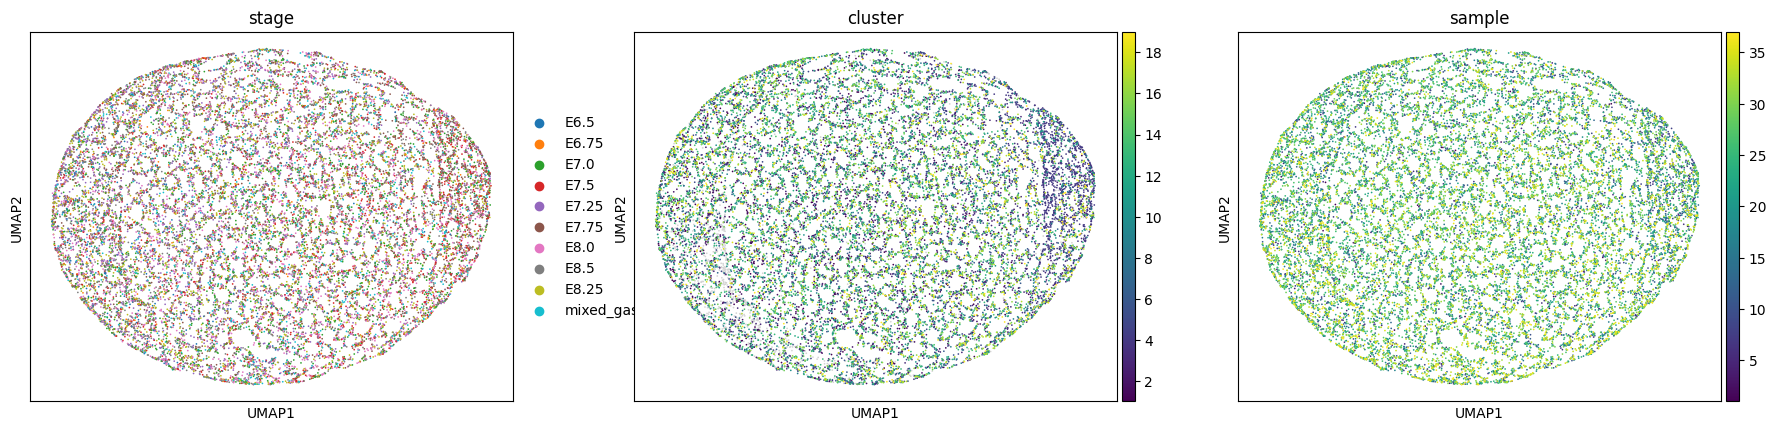

In [ ]:
sc.pl.umap(adata, color=["stage", "cluster", "sample"], ncols=3)

In [ ]:
W = model.get_generator_mask().cpu().detach().numpy()
W

array([[0.02398898, 0.11346396, 0.08920421, ..., 0.02394227, 0.00886712,
        0.05953641],
       [0.01677421, 0.01282992, 0.01624228, ..., 0.0207683 , 0.01744659,
        0.00422652],
       [0.01519237, 0.08973034, 0.03537045, ..., 0.03101954, 0.07456991,
        0.08208404],
       ...,
       [0.02692087, 0.01539707, 0.06147298, ..., 0.03018548, 0.01179794,
        0.03229391],
       [0.00170922, 0.04042161, 0.10441104, ..., 0.05582741, 0.05659244,
        0.0147693 ],
       [0.11501278, 0.01531572, 0.11750942, ..., 0.04516904, 0.06398097,
        0.00539089]], dtype=float32)

In [ ]:
out_dir = "out/adata/"
model_type = 'DS'

In [ ]:
# z = pd.read_csv(out_dir + "/" + model_type + "_z_mean.csv", delimiter=",", header=None)
z = z_mean.detach().cpu().numpy()
ZTZ, variance_explained = Z_covariance(z)
idx = np.argsort(variance_explained)[::-1]
z = pd.DataFrame(z)
Z_df_ordered = pd.DataFrame(z.values[:, idx]).add_prefix('z')
zs = [f"z{i}" for i in range(z.shape[1])]

variance_explained

array([5.14365441e-01, 4.00538354e-01, 5.46557604e-02, 3.04033366e-02,
       1.37597424e-05, 5.01882026e-06, 2.38659112e-06, 2.13598899e-06,
       2.08935720e-06, 1.86285738e-06, 1.63498595e-06, 1.36223980e-06,
       3.72876979e-07, 1.22652021e-06, 1.11795897e-06, 1.06160600e-06,
       8.72833654e-07, 7.96603801e-07, 6.76917994e-07, 7.31764975e-07])

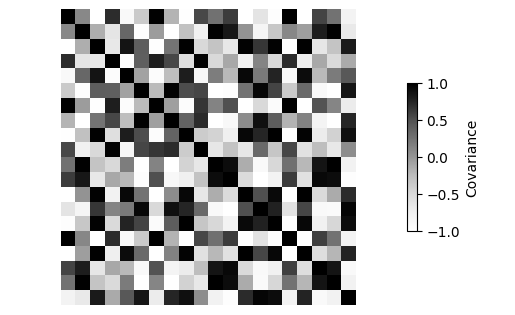

<Figure size 500x500 with 0 Axes>

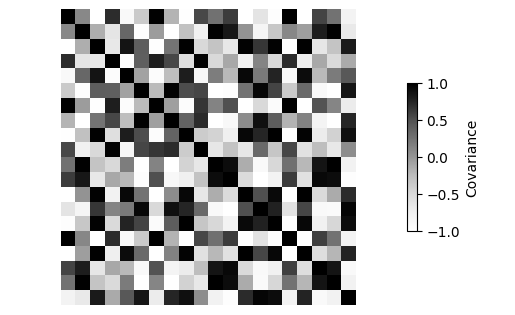

In [ ]:
z_cov_plot(ZTZ, variance_explained, idx)

In [ ]:
mutual_information_gap(Z_df_ordered, zs, zs)

0.5491217615056068

In [ ]:
W = model.get_generator_mask().cpu().detach().numpy()
# W = pd.read_csv(out_dir + "/" + model_type + "_W.csv", delimiter=",", header=None)
W_df = pd.DataFrame(W).add_prefix('w')
W_df_ordered = pd.DataFrame(W_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = adata.var_names
W_df_ordered = adata.var.loc[W_df_ordered.index].join(W_df_ordered)


['Ccnd2' 'Malat1' 'Hist3h2ba' 'Oat' 'Dnajc3']
['Malat1' 'Bex3' 'Hmgb1' 'Ldhb' 'mt-Cytb']
['Gm45716' 'Malat1' 'Bex3' 'Comt' 'Lmo4']


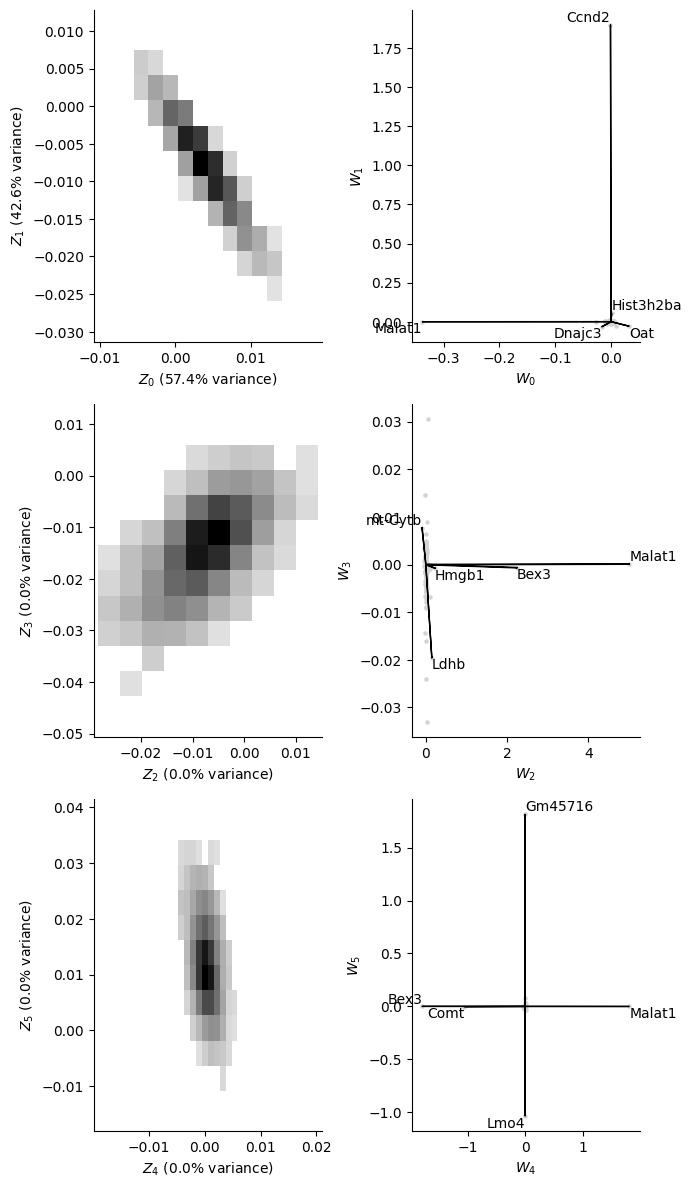

In [ ]:
plot_genes(Z_df_ordered, W_df_ordered, variance_explained, idx)

### sparse VAE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# model_type = 'DS'
# model_type = 'VAE'
model_type = 'spikeslab'
n_components = 20

input_dim = x.shape[1]
latent_dim = n_components
batch_size = 1000
nepoch = 100

hidden_dim = 128

lambda1 = 1
lambda0 = 10
a=1
b=input_dim

lr=1e-2

sigmas_init = np.std(x, axis=0)
sig_quant = 0.9
sig_df = 3

sig_est = np.quantile(sigmas_init, q=0.05)
if sig_est==0:
    sig_est = 1e-3

q_chi = chi2.ppf(1-sig_quant, sig_df)
sig_scale = sig_est * sig_est * q_chi / sig_df

z_prior='standard'
if model_type == 'spikeslab':
    model = SparseVAESpikeSlab(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim,z_prior=z_prior,sigma_prior_scale=sig_scale,
                                        loss_type='mse', sigmas_init=sigmas_init, lambda0=lambda0, lambda1=lambda1, row_normalize=False)
if model_type == 'VAE':
    model = VAE(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim,z_prior=z_prior,sigma_prior_scale=sig_scale,
                                        loss_type='mse', sigmas_init=sigmas_init, beta_vae=2)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(torch.tensor(x, dtype=torch.float), batch_size=batch_size,                                       shuffle=True)

l = None

for epoch in range(nepoch):
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        rec_loss, kl_loss, reg_loss, sig_loss = model.vae_loss(data.to(device))
        loss = rec_loss + kl_loss + reg_loss
        loss.backward()
        optimizer.step()

        if model_type == 'spikeslab':
            p_star = model.p_star.detach()
            thetas = model.thetas.detach()

            for k in range(p_star.shape[1]):
                p_star[:, k] = thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) /\
                        (thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) +\
                        (1-thetas[k]) * torch.exp(-lambda0 * model.W[:, k].abs()))

                thetas[k] = (p_star[:, k].sum() + a - 1) / (a + b + input_dim - 2)


    if epoch % 10 == 0:
        print("Epoch:", epoch, "Total loss:", f"{loss.detach().item():.3}", "Likelihood:", f"{rec_loss.detach().item():.3}",
                "KL loss:", f"{kl_loss.detach().item():.3}", "W loss:", f"{reg_loss.detach().item():.3}")



Epoch: 0 Total loss: 15.4 Likelihood: 0.435 KL loss: 0.000893 W loss: 14.9
Epoch: 10 Total loss: 1.23 Likelihood: 0.0645 KL loss: 3.03e-06 W loss: 1.16
Epoch: 20 Total loss: 0.277 Likelihood: 0.0297 KL loss: 1.33e-06 W loss: 0.248
Epoch: 30 Total loss: 0.25 Likelihood: 0.0184 KL loss: 1.23e-05 W loss: 0.232
Epoch: 40 Total loss: 0.239 Likelihood: 0.0122 KL loss: 8.06e-07 W loss: 0.227
Epoch: 50 Total loss: 0.229 Likelihood: 0.00882 KL loss: 9.04e-07 W loss: 0.22
Epoch: 60 Total loss: 0.226 Likelihood: 0.00668 KL loss: 5.03e-07 W loss: 0.22
Epoch: 70 Total loss: 0.225 Likelihood: 0.00542 KL loss: 3.97e-07 W loss: 0.219
Epoch: 80 Total loss: 0.22 Likelihood: 0.00416 KL loss: 2.29e-07 W loss: 0.216
Epoch: 90 Total loss: 0.219 Likelihood: 0.00352 KL loss: 6.62e-07 W loss: 0.216


In [ ]:
# Sparse VAE without sigma-loss

model_type = 'spikeslab'
n_components = 20


In [ ]:
out_dir = "out/adata/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
torch.save(model.state_dict(), "out/" + "adata" + model_type)

z_mean, logvar = model.encode(torch.tensor(x, dtype=torch.float).to(device))

np.savetxt(out_dir + "/" + model_type + "_z_mean.csv", z_mean.detach().cpu().numpy(), delimiter=",")
np.savetxt(out_dir + "/" + model_type + "_sigmas.csv", model.log_sigmas.detach().cpu().exp().numpy(), delimiter=",")

if model_type=='spikeslab':
    np.savetxt(out_dir + "/" + model_type + "_W.csv", model.W.detach().cpu().numpy(), delimiter=",")
    np.savetxt(out_dir + "/" + model_type + "_p_star.csv", model.p_star.detach().cpu().numpy(), delimiter=",")
    np.savetxt(out_dir + "/" + model_type + "_thetas.csv", model.thetas.detach().cpu().numpy(), delimiter=",")


In [ ]:
# Heldout negative log likelihood
model.eval()
tr = torch.tensor(x, dtype=torch.float).to(device)

with torch.no_grad():
    x_mean, z, z_mean, z_log_var = model(tr)
    x_loss = model.reconstruction_loss(x_mean, tr).cpu().detach().numpy()
print(x_loss)


0.0029761887


In [ ]:
# Heldout negative log likelihood
model.eval()
tr = torch.tensor(x, dtype=torch.float).to(device)

with torch.no_grad():
    x_mean, z, z_mean, z_log_var = model(tr)
    x_loss = model.reconstruction_loss(x_mean, tr).cpu().detach().numpy()
print(x_loss)


0.0029761852


In [ ]:
jaccard(x, x_mean.detach().cpu().numpy(), int(x.shape[1]*0.2))

0.3559322033898305

In [ ]:
key_genes = visualize_mask_as_topics()
np.savetxt('sparseVAE_topicGenes.txt', key_genes)

<ipython-input-7-0e87c0fe5f38>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Topic 0: [('Stxbp6', 0.0055437614), ('Arid5b', 0.0052576126), ('Cpne3', 0.0052386597), ('Tgfb2', 0.0049478468), ('Eea1', 0.004915496), ('St3gal5', 0.004648257), ('Tpcn1', 0.0045962045), ('Krt19', 0.0045869816), ('Gng11', 0.0045820624), ('Lamb1', 0.004495093)]
Topic 1: [('Ipo11', 0.005295233), ('Rspo3', 0.0049386644), ('Hspa8', 0.004893075), ('Prnp', 0.0045905546), ('Etv2', 0.0043846006), ('Glul', 0.0040556854), ('Fhl2', 0.0038765022), ('Slc9a3r1', 0.0038726986), ('Dnmt3l', 0.0038409182), ('Ube2l6', 0.003723249)]
Topic 2: [('Tpbg', 0.0062582544), ('Tspan7', 0.005276749), ('Ccnjl', 0.004506777), ('Tln2', 0.0044264644), ('Gjb5', 0.004247417), ('Afap1l1', 0.004234645), ('Gm10076', 0.004107835), ('Ubb', 0.003979884), ('Fabp7', 0.00397006), ('Fgg', 0.0038844184)]
Topic 3: [('Spin2c', 0.006459023), ('Soat2', 0.005200038), ('Crabp2', 0.0049481275), ('Tspan33', 0.0048106858), ('Cxcl12', 0.004689009), ('Pdlim5', 0.0046307645), ('Rasl11a', 0.0045162933), ('2610528J11Rik', 0.004507513), ('Tmem47',

In [ ]:
# plot the latent dimension coordinates for each cell
adata.obsm["X_spvae"] = z_mean.cpu().detach().numpy()
sc.pp.neighbors(adata, use_rep="X_spvae", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)



/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


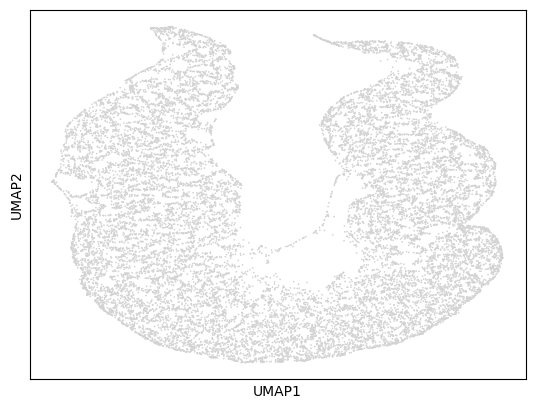

In [ ]:
sc.pl.umap(adata, ncols=3)

In [ ]:
W = model.get_generator_mask().cpu().detach().numpy()
W

array([[-1.37862493e-03,  2.20862497e-03, -6.47613124e-05, ...,
        -1.33678608e-04,  7.96508102e-04, -2.25244067e-03],
       [-1.45899283e-03, -8.13234947e-04, -1.21441344e-03, ...,
        -6.92184432e-04, -8.21724007e-06, -8.86251873e-05],
       [-5.06554963e-04, -1.74332899e-03,  2.76655937e-03, ...,
         2.02458841e-03,  1.56815862e-03,  2.03904044e-03],
       ...,
       [ 1.09540694e-03,  1.58688030e-03,  1.20265664e-04, ...,
         3.99007549e-04, -1.39734207e-03, -2.13117091e-04],
       [ 9.15747252e-04, -1.90185092e-03,  1.33366697e-03, ...,
         2.55788420e-03, -1.06723106e-03,  9.50580405e-04],
       [-2.05279546e-04, -4.76260640e-04, -1.04138523e-03, ...,
        -3.06497153e-04, -1.37491082e-03, -1.37455459e-03]], dtype=float32)

In [ ]:
out_dir = "out/adata/"
model_type = 'spikeslab'

In [ ]:
z = pd.read_csv(out_dir + "/" + model_type + "_z_mean.csv", delimiter=",", header=None)
# z = z_mean.detach().cpu().numpy()
ZTZ, variance_explained = Z_covariance(z)
idx = np.argsort(variance_explained)[::-1]
z = pd.DataFrame(z)
Z_df_ordered = pd.DataFrame(z.values[:, idx]).add_prefix('z')
zs = [f"z{i}" for i in range(z.shape[1])]

variance_explained

array([7.75573584e-01, 1.94672821e-01, 2.25289038e-02, 7.21555370e-03,
       8.33789629e-07, 7.23663516e-07, 6.73681144e-07, 6.35138139e-07,
       6.24919932e-07, 4.37127607e-07, 4.66685825e-07, 4.73520902e-07,
       4.86172082e-07, 5.78660563e-07, 5.00360239e-07, 5.14698272e-07,
       5.62127111e-07, 5.36641692e-07, 5.48057728e-07, 5.42779022e-07])

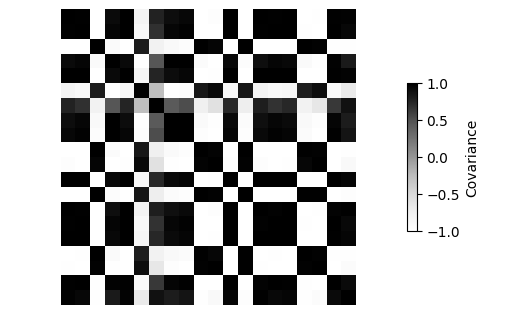

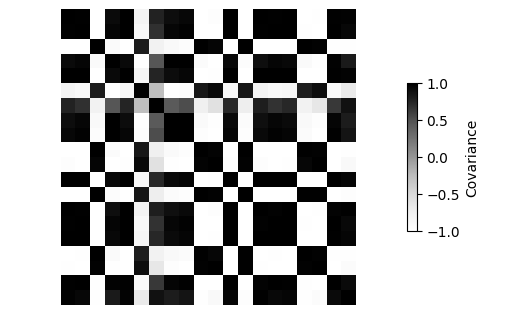

In [ ]:
z_cov_plot(ZTZ, variance_explained, idx)

In [ ]:
mutual_information_gap(Z_df_ordered, zs, zs)

0.8866380059837342

In [ ]:
# W = model.get_generator_mask().cpu().detach().numpy()
W = pd.read_csv(out_dir + "/" + model_type + "_W.csv", delimiter=",", header=None)
W_df = pd.DataFrame(W).add_prefix('w')
W_df_ordered = pd.DataFrame(W_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = adata.var_names
W_df_ordered = adata.var.loc[W_df_ordered.index].join(W_df_ordered)


['Stxbp6' 'Ipo11' 'Cpne3' 'Arid5b' 'Tgfb2']
['Spin2c' 'Tpbg' 'Cxcl12' 'Soat2' 'Tspan7']
['Eea1' 'Sec14l2' 'Degs1' 'Ccnjl' 'Scly']


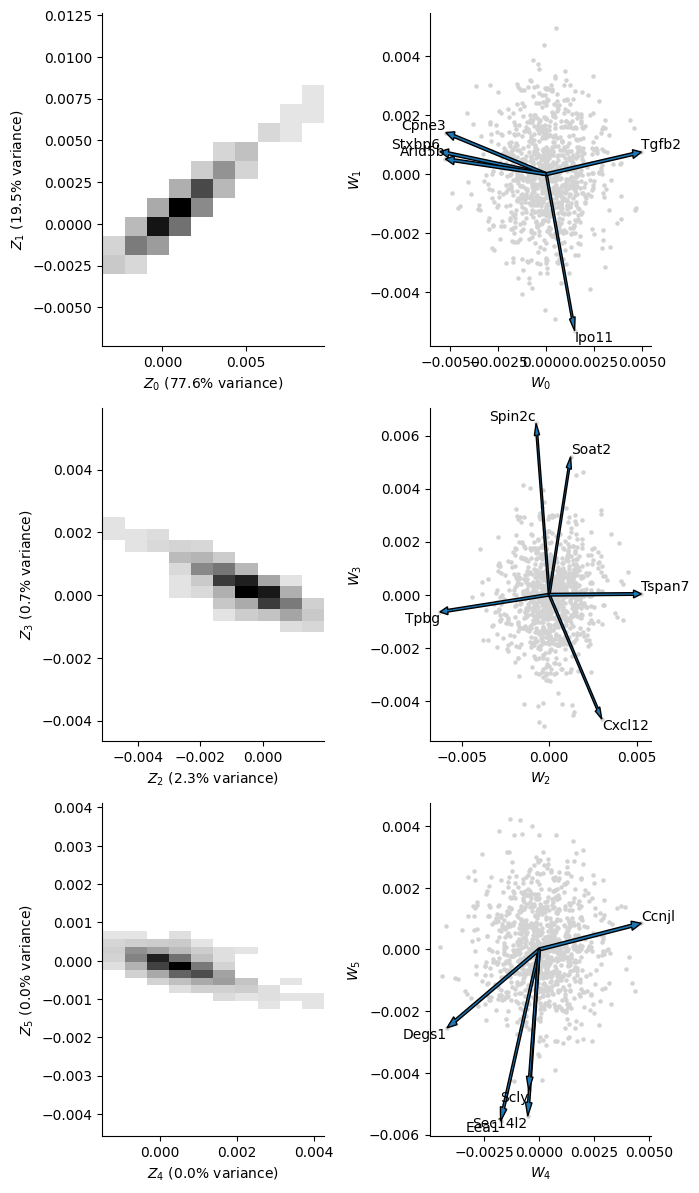

In [ ]:
plot_genes(Z_df_ordered, W_df_ordered, variance_explained, idx)

### Beta VAE

In [ ]:
# Beta-vae (beta=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# model_type = 'DS'
model_type = 'VAE'
# model_type = 'spikeslab'
n_components = 20

input_dim = x.shape[1]
latent_dim = n_components
batch_size = 1000
nepoch = 100

hidden_dim = 128

lambda1 = 1
lambda0 = 10
a=1
b=input_dim

lr=1e-2

sigmas_init = np.std(x, axis=0)
sig_quant = 0.9
sig_df = 3

sig_est = np.quantile(sigmas_init, q=0.05)
if sig_est==0:
    sig_est = 1e-3

q_chi = chi2.ppf(1-sig_quant, sig_df)
sig_scale = sig_est * sig_est * q_chi / sig_df

z_prior='standard'
if model_type == 'spikeslab':
    model = SparseVAESpikeSlab(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim,z_prior=z_prior,sigma_prior_scale=sig_scale,
                                        loss_type='mse', sigmas_init=sigmas_init, lambda0=lambda0, lambda1=lambda1, row_normalize=False)
if model_type == 'VAE':
    model = VAE(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim,z_prior=z_prior,sigma_prior_scale=sig_scale,
                                        loss_type='mse', sigmas_init=sigmas_init, beta_vae=2)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(torch.tensor(x, dtype=torch.float), batch_size=batch_size,                                       shuffle=True)

l = None

for epoch in range(nepoch):
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        rec_loss, kl_loss, reg_loss, sig_loss = model.vae_loss(data.to(device))
        loss = rec_loss + kl_loss + reg_loss
        loss.backward()
        optimizer.step()

        if model_type == 'spikeslab':
            p_star = model.p_star.detach()
            thetas = model.thetas.detach()

            for k in range(p_star.shape[1]):
                p_star[:, k] = thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) /\
                               (thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) + (1-thetas[k]) * torch.exp(-lambda0 * model.W[:, k].abs()))

                thetas[k] = (p_star[:, k].sum() + a - 1) / (a + b + input_dim - 2)


    if epoch % 10 == 0:
        print("Epoch:", epoch, "Total loss:", f"{loss.detach().item():.3}", "Likelihood:", f"{rec_loss.detach().item():.3}",
                "KL loss:", f"{kl_loss.detach().item():.3}",  "W loss:", f"{reg_loss.detach().item():.3}")



Epoch: 0 Total loss: 0.41 Likelihood: 0.408 KL loss: 0.00217 W loss: 0.0
Epoch: 10 Total loss: 0.0653 Likelihood: 0.0653 KL loss: 1.23e-05 W loss: 0.0
Epoch: 20 Total loss: 0.0307 Likelihood: 0.0307 KL loss: 3.48e-06 W loss: 0.0
Epoch: 30 Total loss: 0.0184 Likelihood: 0.0184 KL loss: 1.35e-06 W loss: 0.0
Epoch: 40 Total loss: 0.0125 Likelihood: 0.0125 KL loss: 5.21e-07 W loss: 0.0
Epoch: 50 Total loss: 0.00904 Likelihood: 0.00904 KL loss: 1.02e-06 W loss: 0.0
Epoch: 60 Total loss: 0.00705 Likelihood: 0.00705 KL loss: 7.84e-07 W loss: 0.0
Epoch: 70 Total loss: 0.0053 Likelihood: 0.0053 KL loss: 1.49e-07 W loss: 0.0
Epoch: 80 Total loss: 0.00425 Likelihood: 0.00425 KL loss: 1.03e-07 W loss: 0.0
Epoch: 90 Total loss: 0.00356 Likelihood: 0.00355 KL loss: 5.1e-07 W loss: 0.0


In [ ]:
# Heldout negative log likelihood
model.eval()
tr = torch.tensor(x, dtype=torch.float).to(device)

with torch.no_grad():
    x_mean, z, z_mean, z_log_var = model(tr)
    x_loss = model.reconstruction_loss(x_mean, tr).cpu().detach().numpy()
x_loss

array(0.00296872, dtype=float32)

In [ ]:
jaccard(x, x_mean.detach().cpu().numpy(), int(x.shape[1]*0.2))

0.45985401459854014

In [ ]:
# z = pd.read_csv(out_dir + "/" + model_type + "_z_mean.csv", delimiter=",", header=None)
z = z_mean.detach().cpu().numpy()
ZTZ, variance_explained = Z_covariance(z)
idx = np.argsort(variance_explained)[::-1]
z = pd.DataFrame(z)
Z_df_ordered = pd.DataFrame(z.values[:, idx]).add_prefix('z')
zs = [f"z{i}" for i in range(z.shape[1])]

variance_explained

array([5.73770533e-01, 4.26228211e-01, 2.49461198e-08, 3.15744590e-08,
       3.37583714e-08, 3.94828059e-08, 4.64649935e-08, 1.01094024e-07,
       9.94071690e-08, 9.86044978e-08, 9.59191238e-08, 5.95465021e-08,
       8.98977389e-08, 8.81125633e-08, 8.38099641e-08, 7.99837301e-08,
       7.45001347e-08, 6.74798814e-08, 7.14276803e-08, 6.97445994e-08])

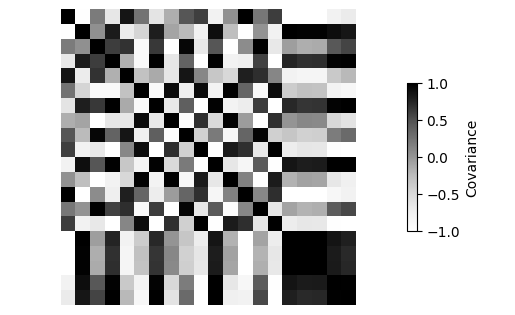

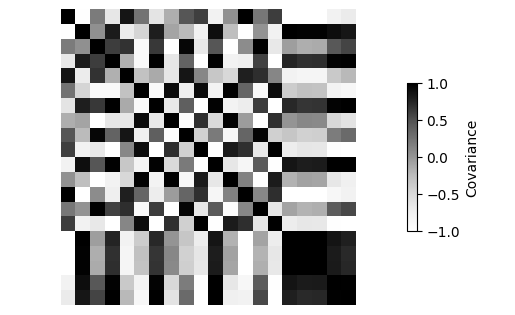

In [ ]:
z_cov_plot(ZTZ, variance_explained, idx)

In [ ]:
mutual_information_gap(Z_df_ordered, zs, zs)

0.4782938638390963